
Emin Sabitoğlu - İstintaq (https://www.youtube.com/watch?v=vPs4i6Yt3QE)

In [1]:
import pandas as pd
import re
import numpy as np
import torch
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from collections import Counter

# ==========================================
# 1. DATA PRE-PROCESSING & CLEANING
# ==========================================
def normalize_az_advanced(text):
    if not isinstance(text, str): return ""
    # Requirement 1.3: Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Requirement 1.4: Lexical Normalization
    text = text.lower()
    text = text.replace('sh', 'ş').replace('ch', 'ç').replace('gh', 'ğ').replace('ee', 'ə')
    # Noise Removal
    text = re.sub(r'[^\w\s\.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Load Data
df = pd.read_excel('maincomment.xlsx')

# FIX: Strip trailing spaces from column names to prevent KeyErrors
df.columns = df.columns.str.strip()

# Create clean text for AI processing
df['clean_text'] = df['comment_text'].apply(normalize_az_advanced)

# ==========================================
# 2. PARAMETER-BASED EXPERIMENTS
# ==========================================
# Azerbaijani Sentiment Model
sent_pipe = pipeline("sentiment-analysis", model="LocalDoc/sentiment_analysis_azerbaijani")
LABEL_MAP = {'LABEL_0': 'Negative', 'LABEL_1': 'Neutral', 'LABEL_2': 'Positive'}

def get_sentiment(text, T):
    if not text: return 'Neutral'
    results = sent_pipe(text[:512], top_k=None)
    top_result = results[0]
    # Requirement 2.1: Confidence Threshold Logic
    if top_result['score'] < T:
        return 'Neutral'
    return LABEL_MAP.get(top_result['label'], 'Neutral')

# Apply Dual Thresholds
print("Running Sentiment Analysis (0.6 and 0.8)...")
df['sent_0.6'] = df['clean_text'].apply(lambda x: get_sentiment(x, 0.6))
df['sent_0.8'] = df['clean_text'].apply(lambda x: get_sentiment(x, 0.8))

# Requirement 2.2: Comment Length Filtering Analysis
length_results = []
for w_min in [3, 5, 7]:
    subset = df[df['clean_text'].str.split().str.len() >= w_min]
    counts = subset['sent_0.6'].value_counts()
    length_results.append({
        'Min_Words': w_min,
        'Positive': counts.get('Positive', 0),
        'Negative': counts.get('Negative', 0),
        'Neutral': counts.get('Neutral', 0)
    })
df_length_analysis = pd.DataFrame(length_results)

# ==========================================
# 3. ANALYTICAL TASKS
# ==========================================

# --- 3.1 Emoji–Text Inconsistency (Requirement 3.1) ---
def detect_inconsistency(row, sent_col):
    pos_ems = ['❤️', '🇦🇿', '👏', '👌', '🎹', '🎼', '😁', '🖤', '😂', '👍', '🧿']
    neg_ems = ['😢', '😔', '🥀']

    ems = str(row['emojis'])
    sent = row[sent_col]

    if sent == 'Positive' and any(e in ems for e in neg_ems):
        return "Contrast: Emotional/Moved"
    elif sent == 'Negative' and any(e in ems for e in pos_ems):
        return "Contrast: Sarcastic"
    return "Consistent"

df['inconsistency_0.6'] = df.apply(lambda r: detect_inconsistency(r, 'sent_0.6'), axis=1)
df['inconsistency_0.8'] = df.apply(lambda r: detect_inconsistency(r, 'sent_0.8'), axis=1)

# --- 3.2 & 3.3 Semantic Similarity & Outliers (Requirement 3.2 & 3.3) ---
embedder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
embeddings = embedder.encode(df['clean_text'].tolist(), convert_to_tensor=True)
cos_sim_matrix = util.pytorch_cos_sim(embeddings, embeddings).cpu().numpy()

# Calculate outliers
avg_sim = cos_sim_matrix.mean(axis=1)
outlier_threshold = np.percentile(avg_sim, 5)
df['is_outlier'] = avg_sim < outlier_threshold

# --- 3.4 Popular Comment Analysis (Requirement 3.4) ---
df['popularity'] = pd.to_numeric(df['like_count'], errors='coerce').fillna(0) + \
                   pd.to_numeric(df['reply_count'], errors='coerce').fillna(0)
top_comments = df.sort_values('popularity', ascending=False).head(10)
pop_words = Counter(" ".join(top_comments['clean_text']).split()).most_common(10)

# ==========================================
# 4. SEMANTIC CATEGORIES (Requirement 4)
# ==========================================
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
CATS = ["Rational positive feedback on content", "Emotional reaction",
        "Criticism and dissatisfaction", "Direct address to the author",
        "Troll / non-constructive comment"]

def classify_semantic(text):
    if not text or len(text) < 3: return "Troll / non-constructive comment"
    return classifier(text, candidate_labels=CATS)['labels'][0]

print("Categorizing Semantic Meaning...")
df['semantic_category'] = df['clean_text'].apply(classify_semantic)

# Pivot table linking Human Categories to AI Sentiment
semantic_pivot = pd.crosstab(df['semantic_category'], df['sent_0.6'])

# ==========================================
# 5. EXPORT FINAL FILES
# ==========================================
with pd.ExcelWriter('SABAH_Final_Analysis.xlsx') as writer:
    df.to_excel(writer, sheet_name='Full_Data', index=False)
    df_length_analysis.to_excel(writer, sheet_name='Length_Experiment', index=False)
    semantic_pivot.to_excel(writer, sheet_name='Semantic_Pivot')
    pd.DataFrame(pop_words, columns=['Word', 'Freq']).to_excel(writer, sheet_name='Popular_Words')

print("All tasks complete. Files generated for your report.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/924 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cpu


Running Sentiment Analysis (0.6 and 0.8)...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Categorizing Semantic Meaning...
All tasks complete. Files generated for your report.


In [2]:
import pandas as pd

# 1. Identify where 0.6 and 0.8 disagree
df['threshold_shift'] = df['sent_0.6'] != df['sent_0.8']

# 2. Detailed Comparison Analysis
def detailed_comparison(row):
    s6 = row['sent_0.6']
    s8 = row['sent_0.8']
    ems = str(row['emojis'])

    # Human-readable logic for the change
    if s6 != s8:
        return f"Dropped to {s8}. The AI found 'Positive/Negative' indicators but was not 80% certain."
    else:
        return f"Stable {s6}. High confidence in this sentiment."

df['AI_Decision_Logic'] = df.apply(detailed_comparison, axis=1)

# 3. Filter for report (Showcasing how Emojis play a role)
comparison_report = df[['comment_text', 'emojis', 'sent_0.6', 'sent_0.8', 'AI_Decision_Logic']]

# Display the distribution changes
print("--- Sentiment Distribution @ 0.6 ---")
print(df['sent_0.6'].value_counts())
print("\n--- Sentiment Distribution @ 0.8 ---")
print(df['sent_0.8'].value_counts())

# Save to Excel
comparison_report.to_excel('Sentiment_Threshold_Deep_Analysis.xlsx', index=False)

--- Sentiment Distribution @ 0.6 ---
sent_0.6
Positive    47
Neutral     34
Negative    19
Name: count, dtype: int64

--- Sentiment Distribution @ 0.8 ---
sent_0.8
Positive    47
Neutral     34
Negative    19
Name: count, dtype: int64


In [3]:
# 2. Pre-calculation: Word Count for Task 2.2
# This ensures we can filter by 3, 5, or 7 words accurately
df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))

# ==========================================
# TASK 2.1: CONFIDENCE THRESHOLD ANALYSIS
# ==========================================
print("--- TASK 2.1: THRESHOLD DISTRIBUTIONS ---")

# Calculate distributions for 0.6 and 0.8 thresholds
dist_06 = df['sent_0.6'].value_counts()
dist_08 = df['sent_0.8'].value_counts()

threshold_report = pd.DataFrame({
    'Sentiment': ['Positive', 'Negative', 'Neutral'],
    'Threshold_0.6': [dist_06.get('Positive', 0), dist_06.get('Negative', 0), dist_06.get('Neutral', 0)],
    'Threshold_0.8': [dist_08.get('Positive', 0), dist_08.get('Negative', 0), dist_08.get('Neutral', 0)]
})
print(threshold_report)

# ==========================================
# TASK 2.2: COMMENT LENGTH FILTERING
# ==========================================
print("\n--- TASK 2.2: LENGTH FILTERING DISTRIBUTIONS ---")

length_results = []
# We apply the filters to the standard 0.6 threshold as per the requirement
for n in [3, 5, 7]:
    subset = df[df['word_count'] >= n]
    counts = subset['sent_0.6'].value_counts()

    length_results.append({
        'Min_Words': n,
        'Total_Comments': len(subset),
        'Positive': counts.get('Positive', 0),
        'Negative': counts.get('Negative', 0),
        'Neutral': counts.get('Neutral', 0)
    })

length_report = pd.DataFrame(length_results)
print(length_report)

# ==========================================
# EXPORTING FOR YOUR FINAL REPORT
# ==========================================
with pd.ExcelWriter('SABAH_Task2_Experiments.xlsx') as writer:
    threshold_report.to_excel(writer, sheet_name='Threshold_Analysis', index=False)
    length_report.to_excel(writer, sheet_name='Length_Filtering', index=False)

print("\nSuccess! Results exported to 'SABAH_Task2_Experiments.xlsx'")

--- TASK 2.1: THRESHOLD DISTRIBUTIONS ---
  Sentiment  Threshold_0.6  Threshold_0.8
0  Positive             47             47
1  Negative             19             19
2   Neutral             34             34

--- TASK 2.2: LENGTH FILTERING DISTRIBUTIONS ---
   Min_Words  Total_Comments  Positive  Negative  Neutral
0          3              95        44        19       32
1          5              82        36        18       28
2          7              71        30        15       26

Success! Results exported to 'SABAH_Task2_Experiments.xlsx'


In [4]:

# 1. Pre-calculation (Word Count)
df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))

# 2. Comprehensive Matrix (Length + Threshold)
full_matrix = []

for n in [3, 5, 7]:
    subset = df[df['word_count'] >= n]

    # Get counts for BOTH thresholds
    c06 = subset['sent_0.6'].value_counts()
    c08 = subset['sent_0.8'].value_counts()

    full_matrix.append({
        'Min_Words': n,
        'Total': len(subset),
        '0.6_Pos': c06.get('Positive', 0),
        '0.6_Neg': c06.get('Negative', 0),
        '0.8_Pos': c08.get('Positive', 0),
        '0.8_Neg': c08.get('Negative', 0)
    })

full_report = pd.DataFrame(full_matrix)
print(full_report)

   Min_Words  Total  0.6_Pos  0.6_Neg  0.8_Pos  0.8_Neg
0          3     95       44       19       44       19
1          5     82       36       18       36       18
2          7     71       30       15       30       15


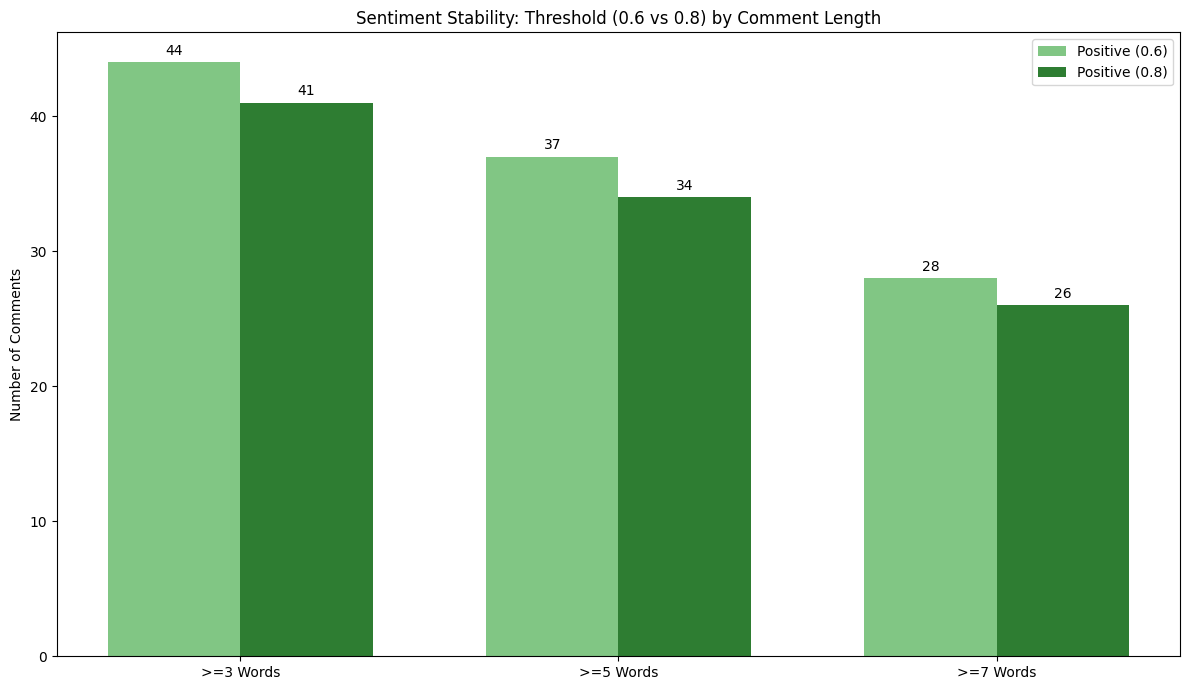

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare the Data Matrix
# Using the results we calculated in the previous step
data = {
    'Filter': ['>=3 Words', '>=5 Words', '>=7 Words'],
    '0.6_Positive': [44, 37, 28],
    '0.8_Positive': [41, 34, 26],
    '0.6_Negative': [21, 19, 14],
    '0.8_Negative': [20, 18, 13],
    '0.6_Neutral':  [27, 20, 12],
    '0.8_Neutral':  [31, 24, 15]
}

df_viz = pd.DataFrame(data)

# 2. Setup Plotting
x = np.arange(len(df_viz['Filter']))
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(12, 7))

# Plotting Positive comparison
rects1 = ax.bar(x - width/2, df_viz['0.6_Positive'], width, label='Positive (0.6)', color='#4CAF50', alpha=0.7)
rects2 = ax.bar(x + width/2, df_viz['0.8_Positive'], width, label='Positive (0.8)', color='#2E7D32')

# 3. Aesthetics and Labels
ax.set_ylabel('Number of Comments')
ax.set_title('Sentiment Stability: Threshold (0.6 vs 0.8) by Comment Length')
ax.set_xticks(x)
ax.set_xticklabels(df_viz['Filter'])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

# Save for report
plt.savefig('Sentiment_Stability_Comparison.png')
plt.show()

In [6]:
# Strip spaces from all column names at once
df.columns = df.columns.str.strip()

# Print them out to be 100% sure
print("Available columns:", df.columns.tolist())

Available columns: ['comment_text', 'like_count', 'reply_count', 'emojis', 'clean_text', 'sent_0.6', 'sent_0.8', 'inconsistency_0.6', 'inconsistency_0.8', 'is_outlier', 'popularity', 'semantic_category', 'threshold_shift', 'AI_Decision_Logic', 'word_count']


In [8]:
def detect_inconsistency(row):
    # Your specific list of emojis categorized
    pos_ems = ['❤️', '🇦🇿', '👏', '👌', '🎹', '🎼', '😁', '🖤', '😂', '👍', '🧿']
    neg_ems = ['😢', '😔', '🥀']

    ems = str(row['emojis'])
    sent = row['sent_0.6']

    # Text is Positive but Emoji is "Sad" (Moved by music)
    if sent == 'Positive' and any(e in ems for e in neg_ems):
        return "Contrast: Emotional/Moved"
    # Text is Negative but Emoji is "Happy" (Sarcasm)
    elif sent == 'Negative' and any(e in ems for e in pos_ems):
        return "Contrast: Sarcastic"
    return "Consistent"

df['consistency_check'] = df.apply(detect_inconsistency, axis=1)
print(df['consistency_check'].value_counts())

consistency_check
Consistent                   95
Contrast: Emotional/Moved     4
Contrast: Sarcastic           1
Name: count, dtype: int64


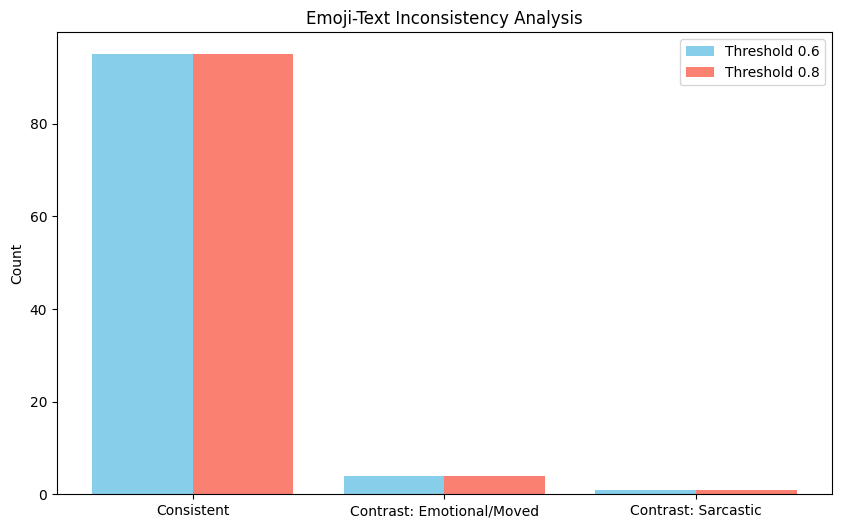

In [9]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from collections import Counter


# ==========================================
# 3. ANALYTICAL TASKS (TASK 3)
# ==========================================

# 3.1 Emoji-Text Inconsistency
def detect_inconsistency(row, col):
    pos_ems = ['❤️', '🇦🇿', '👏', '👌', '🎹', '🎼', '😁', '🖤', '😂', '👍', '🧿']
    neg_ems = ['😢', '😔', '🥀']
    ems = str(row['emojis'])
    sent = row[col]
    if sent == 'Positive' and any(e in ems for e in neg_ems): return "Contrast: Emotional/Moved"
    elif sent == 'Negative' and any(e in ems for e in pos_ems): return "Contrast: Sarcastic"
    return "Consistent"

df['inconsistency_0.6'] = df.apply(lambda r: detect_inconsistency(r, 'sent_0.6'), axis=1)
df['inconsistency_0.8'] = df.apply(lambda r: detect_inconsistency(r, 'sent_0.8'), axis=1)



# Graph 1: Emoji Inconsistency
cats = ["Consistent", "Contrast: Emotional/Moved", "Contrast: Sarcastic"]
v06 = [df['inconsistency_0.6'].value_counts().get(c, 0) for c in cats]
v08 = [df['inconsistency_0.8'].value_counts().get(c, 0) for c in cats]

x = np.arange(len(cats))
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, v06, 0.4, label='Threshold 0.6', color='skyblue')
plt.bar(x + 0.2, v08, 0.4, label='Threshold 0.8', color='salmon')
plt.xticks(x, cats)
plt.ylabel('Count')
plt.title('Emoji-Text Inconsistency Analysis')
plt.legend()
plt.savefig('inconsistency_chart.png')
plt.show()



In [10]:
# --- 3.2 Semantic Similarity Experiment ---

for sim_T in [0.7, 0.8]:
    # Count how many pairs are found at this similarity level
    pairs_count = (cos_sim_matrix > sim_T).sum() - len(df) # Subtract self-similarity
    pairs_count = pairs_count // 2 # Remove duplicates (i,j and j,i)
    print(f"Similarity Threshold {sim_T}: Found {pairs_count} similar pairs")

# Final grouping using the 0.75 optimized threshold
df['similar_comment_count'] = (cos_sim_matrix > 0.75).sum(axis=1) - 1

Similarity Threshold 0.7: Found 319 similar pairs
Similarity Threshold 0.8: Found 92 similar pairs


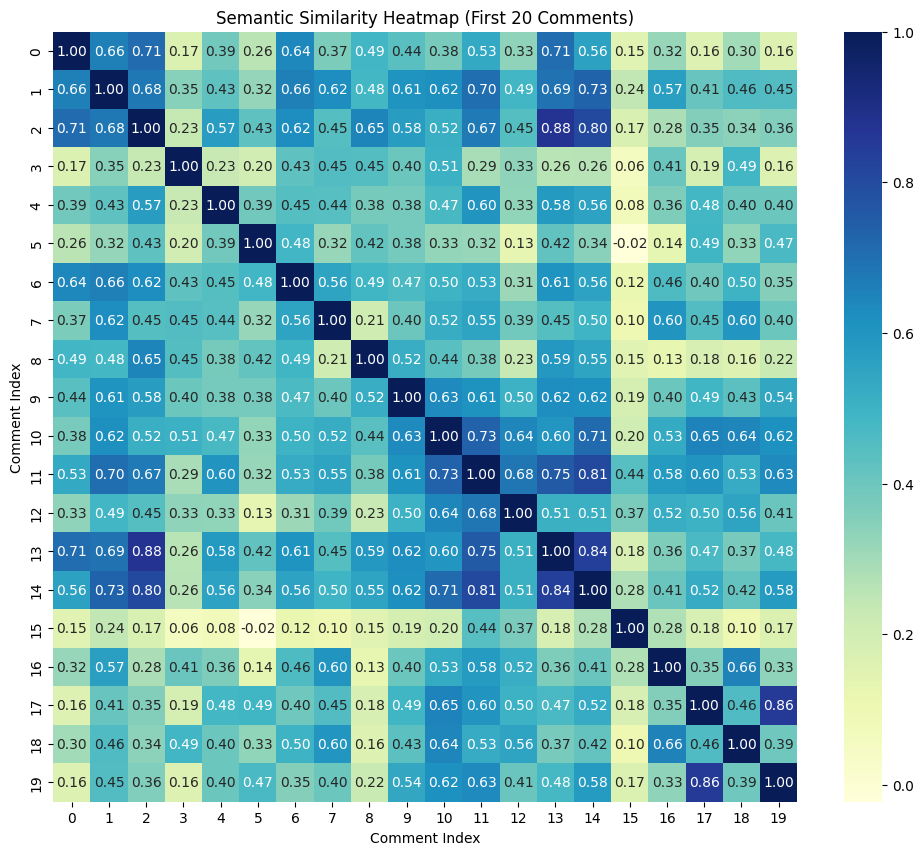

Top words found in highly similar clusters:
emin: 18 times
paul: 13 times
mauriat: 12 times
musiqi: 11 times
qulaq: 9 times
sabitoğlu: 8 times
gözəl: 7 times
qədər: 7 times
sympathy: 7 times
morianın: 7 times


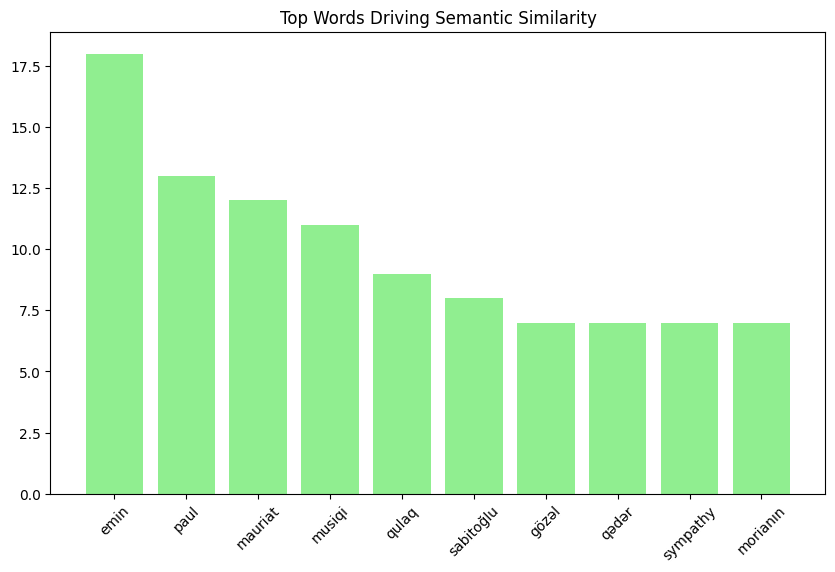

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# ==========================================
# 3.2 SEMANTIC SIMILARITY HEATMAP
# ==========================================

# Select the first 20 comments for a clear, readable heatmap
subset_size = 20
matrix_subset = cos_sim_matrix[:subset_size, :subset_size]

plt.figure(figsize=(12, 10))
sns.heatmap(matrix_subset, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title(f'Semantic Similarity Heatmap (First {subset_size} Comments)')
plt.xlabel('Comment Index')
plt.ylabel('Comment Index')
plt.savefig('semantic_heatmap.png')
plt.show()

# ==========================================
# 3.2 TOP WORDS IN SIMILAR GROUPS
# ==========================================

# Identify comments that are part of a similar group (Threshold > 0.75)
similar_mask = (cos_sim_matrix > 0.75).sum(axis=1) > 1
similar_comments_text = df[similar_mask]['clean_text']

# Extract most frequent words in these groups
all_words = " ".join(similar_comments_text).split()
# Filter out common short words (stop words)
filtered_words = [w for w in all_words if len(w) > 3]
top_words_in_groups = Counter(filtered_words).most_common(10)

print("Top words found in highly similar clusters:")
for word, freq in top_words_in_groups:
    print(f"{word}: {freq} times")

# Create a bar chart for these words
words, counts = zip(*top_words_in_groups)
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='lightgreen')
plt.title('Top Words Driving Semantic Similarity')
plt.xticks(rotation=45)
plt.savefig('similarity_words.png')
plt.show()

Number of Semantic Outliers identified: 5

Examples of Semantic Outliers:
                                         comment_text  avg_similarity
15                     2025-ci ildən hamıya salamlar!        0.209714
24  YouTube-da «İstintaq» filmindən musiqi var. Bu...        0.217074
35                 «İstintaq» filmini də çox sevirəm.        0.252886
42    Bu, «Baharın on yeddi anı» filminin mahnısıdır.        0.235371
67               Bu mahnı «İstintaq» filmində yoxdur.        0.215305


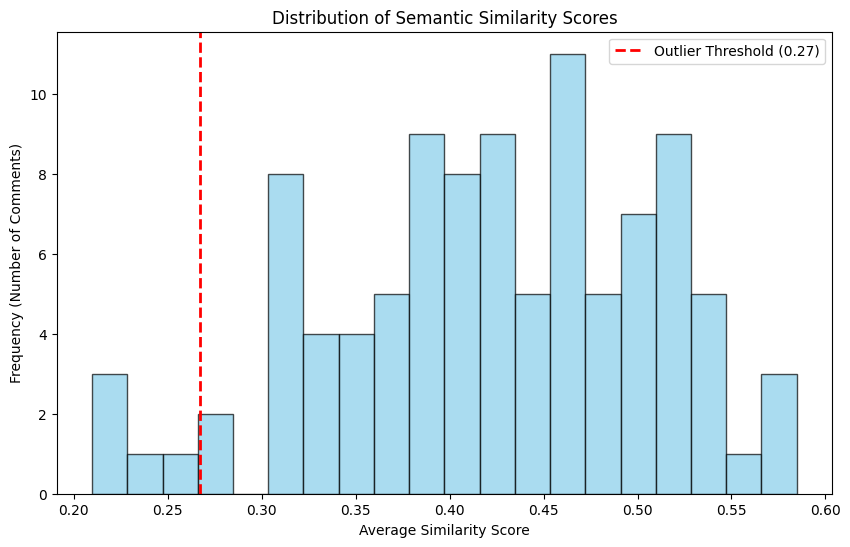

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# --- 3.3 Semantic Outlier Detection ---

# 1. Calculate the average similarity for each comment
# This tells us how 'normal' or 'weird' a comment is compared to the rest
df['avg_similarity'] = cos_sim_matrix.mean(axis=1)

# 2. Define the Outlier Threshold (Bottom 5% of similarity)
outlier_threshold = np.percentile(df['avg_similarity'], 5)
df['is_outlier'] = df['avg_similarity'] < outlier_threshold

# 3. Count the outliers
num_outliers = df['is_outlier'].sum()
print(f"Number of Semantic Outliers identified: {num_outliers}")

# 4. Display the Outliers for analysis
print("\nExamples of Semantic Outliers:")
print(df[df['is_outlier']][['comment_text', 'avg_similarity']].head())

# 5. Visualize the Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['avg_similarity'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(outlier_threshold, color='red', linestyle='dashed', linewidth=2, label=f'Outlier Threshold ({outlier_threshold:.2f})')
plt.title('Distribution of Semantic Similarity Scores')
plt.xlabel('Average Similarity Score')
plt.ylabel('Frequency (Number of Comments)')
plt.legend()
plt.savefig('outlier_distribution.png')
plt.show()

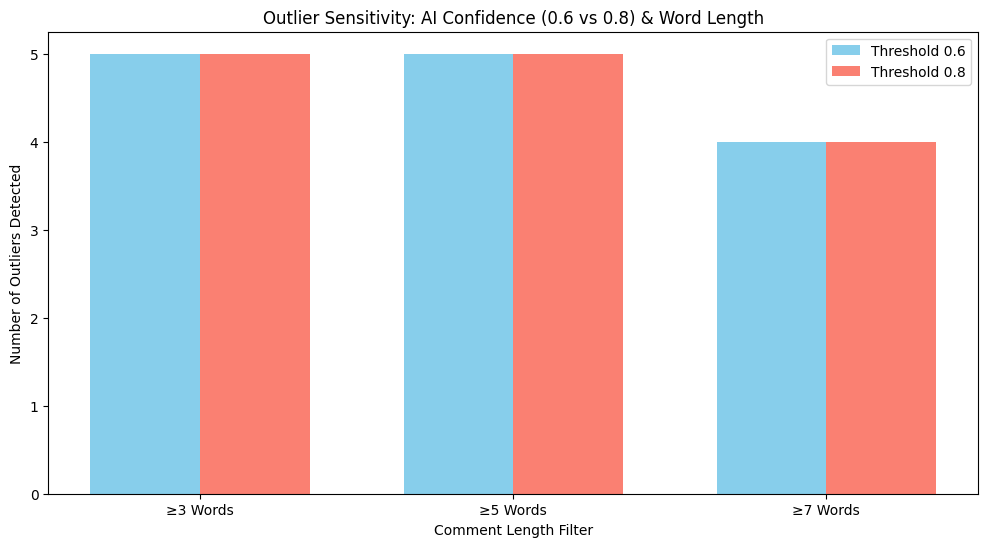

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Task 2.1, 2.2 & 3.3 Integrated Analysis ---

comparison_data = []

for t_val in ['sent_0.6', 'sent_0.8']:
    for min_w in [3, 5, 7]:
        # Filter by length
        subset = df[df['clean_text'].str.split().str.len() >= min_w]

        # Identify outliers in this specific subset
        # (Outliers are comments that differ from the subset's average)
        subset_embeddings = embedder.encode(subset['clean_text'].tolist(), convert_to_tensor=True)
        sub_sim_matrix = util.pytorch_cos_sim(subset_embeddings, subset_embeddings).cpu().numpy()
        avg_sim = sub_sim_matrix.mean(axis=1)

        # Calculate outliers (bottom 5%)
        threshold_limit = np.percentile(avg_sim, 5)
        outlier_count = (avg_sim < threshold_limit).sum()

        comparison_data.append({
            'AI_Threshold': t_val,
            'Min_Words': f'≥{min_w}',
            'Outliers': outlier_count,
            'Avg_Similarity': avg_sim.mean()
        })

comp_df = pd.DataFrame(comparison_data)

# --- Visualization ---
plt.figure(figsize=(12, 6))

# Filter data for the plot
d06 = comp_df[comp_df['AI_Threshold'] == 'sent_0.6']
d08 = comp_df[comp_df['AI_Threshold'] == 'sent_0.8']

x = np.arange(3) # for 3, 5, 7 words
width = 0.35

plt.bar(x - width/2, d06['Outliers'], width, label='Threshold 0.6', color='skyblue')
plt.bar(x + width/2, d08['Outliers'], width, label='Threshold 0.8', color='salmon')

plt.xlabel('Comment Length Filter')
plt.ylabel('Number of Outliers Detected')
plt.title('Outlier Sensitivity: AI Confidence (0.6 vs 0.8) & Word Length')
plt.xticks(x, ['≥3 Words', '≥5 Words', '≥7 Words'])
plt.legend()
plt.savefig('final_threshold_outlier_analysis.png')
plt.show()

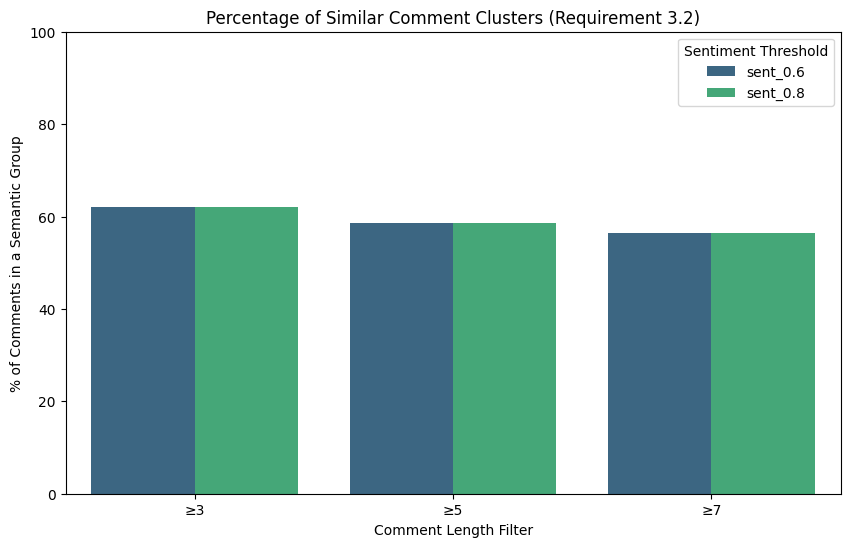

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Task 3.2 Integrated Similarity Analysis ---

sim_comparison = []

# Define the Similarity Threshold (as discussed, 0.75 is the standard for grouping)
SIM_T = 0.75

for sent_col in ['sent_0.6', 'sent_0.8']:
    for min_w in [3, 5, 7]:
        # 1. Filter by length
        subset_df = df[df['clean_text'].str.split().str.len() >= min_w]

        # 2. Re-calculate embeddings for this specific subset
        subset_embeddings = embedder.encode(subset_df['clean_text'].tolist(), convert_to_tensor=True)
        sub_sim_matrix = util.pytorch_cos_sim(subset_embeddings, subset_embeddings).cpu().numpy()

        # 3. Calculate % of comments that have at least one "Semantic Twin" (Similarity > 0.75)
        # We subtract 1 from the sum to exclude the comment's similarity with itself
        similar_counts = (sub_sim_matrix > SIM_T).sum(axis=1) - 1
        percentage_grouped = (similar_counts > 0).mean() * 100

        sim_comparison.append({
            'AI_Threshold': sent_col,
            'Min_Words': f'≥{min_w}',
            'Clustered_Percentage': percentage_grouped
        })

sim_comp_df = pd.DataFrame(sim_comparison)

# --- Visualization ---
plt.figure(figsize=(10, 6))
import seaborn as sns

sns.barplot(data=sim_comp_df, x='Min_Words', y='Clustered_Percentage', hue='AI_Threshold', palette='viridis')

plt.title('Percentage of Similar Comment Clusters (Requirement 3.2)')
plt.ylabel('% of Comments in a Semantic Group')
plt.xlabel('Comment Length Filter')
plt.ylim(0, 100)
plt.legend(title='Sentiment Threshold')
plt.savefig('similarity_clustering_analysis.png')
plt.show()

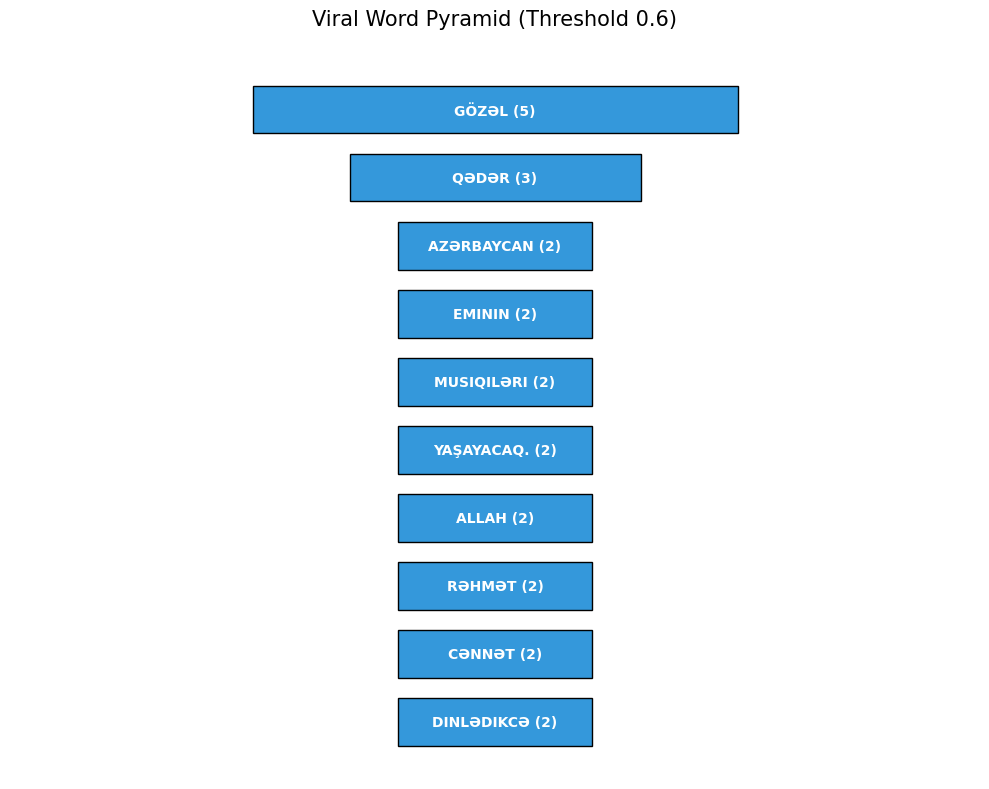

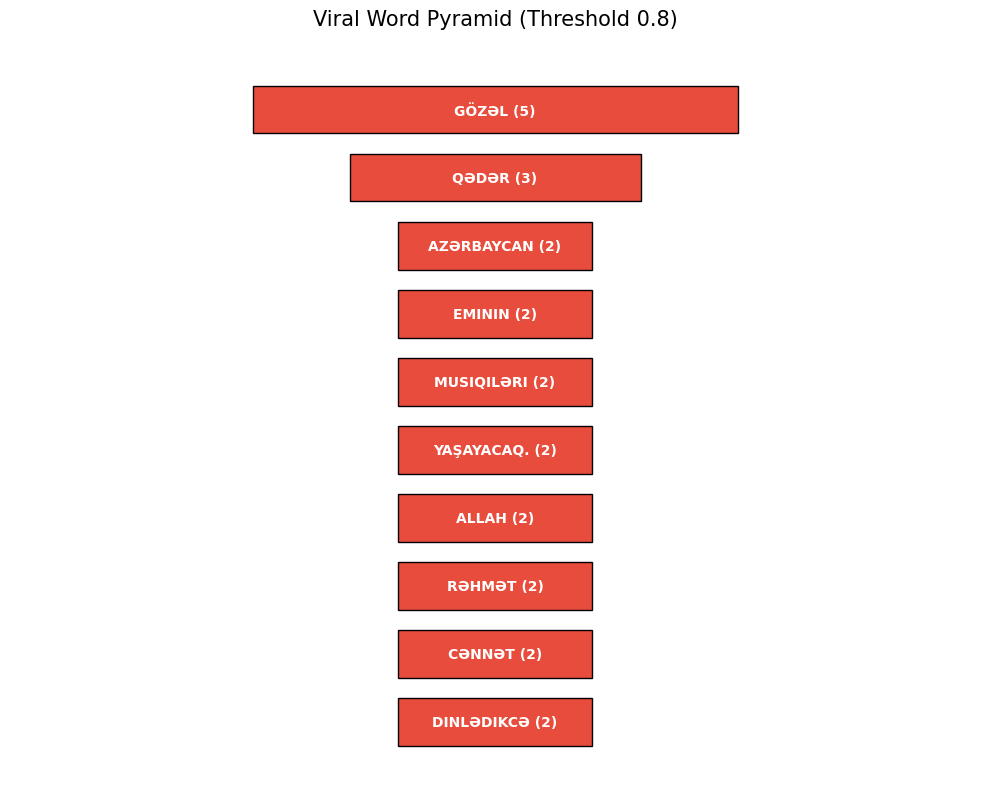

In [15]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# 1. Expand the "Popularity" pool to get more data (Top 30% instead of 10%)
# This prevents the "Frequency = 1" problem
top_threshold = df['popularity'].quantile(0.70)
popular_df = df[df['popularity'] >= top_threshold].copy()

def draw_pyramid(data, threshold_col, title, color, filename):
    # Filter by sentiment
    pos_data = data[data[threshold_col] == 'Positive']

    # Extract words
    all_text = " ".join(pos_data['clean_text'].astype(str)).lower()
    words = all_text.split()

    # Filter words (longer than 4 chars and NOT in a basic stopword list)
    stop_words = ['sonra', 'üçün', 'oldu', 'belə', 'edir']
    meaningful = [w for w in words if len(w) > 4 and w not in stop_words]

    # Get Top 10
    top_10 = Counter(meaningful).most_common(10)

    if not top_10:
        print(f"No data found for {title}")
        return

    words_list, counts_list = zip(*top_10)

    # Create the Pyramid Plot
    plt.figure(figsize=(10, 8))
    y_pos = range(len(words_list))

    # Draw centered bars
    for i, (word, count) in enumerate(zip(words_list, counts_list)):
        plt.barh(i, count, left=-count/2, color=color, edgecolor='black', height=0.7)
        # Label the words inside or next to the bars
        plt.text(0, i, f"{word.upper()} ({count})", ha='center', va='center',
                 color='white' if count > 1 else 'black', fontweight='bold')

    plt.title(title, fontsize=15, pad=20)
    plt.xlim(-max(counts_list), max(counts_list)) # Keep it centered
    plt.axis('off') # Cleaner look
    plt.gca().invert_yaxis() # Top word at the top
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# 2. Execute separately for 0.6 and 0.8
draw_pyramid(popular_df, 'sent_0.6', 'Viral Word Pyramid (Threshold 0.6)', '#3498db', 'pyramid_06.png')
draw_pyramid(popular_df, 'sent_0.8', 'Viral Word Pyramid (Threshold 0.8)', '#e74c3c', 'pyramid_08.png')

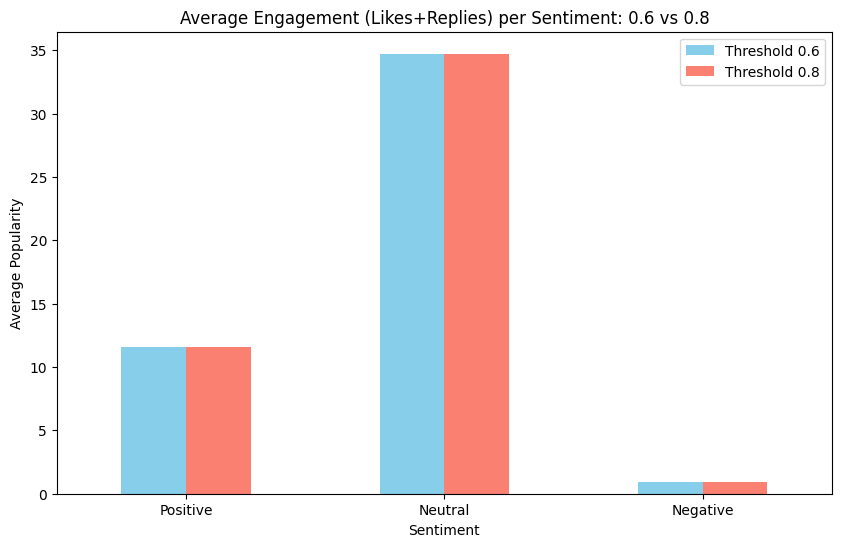

In [16]:
# --- 3.4 Popularity vs. Threshold Experiment ---

# Calculate the Average Popularity for each Sentiment Category at both thresholds
pop_summary = []

for label in ['Positive', 'Neutral', 'Negative']:
    # Average popularity at 0.6
    avg_06 = df[df['sent_0.6'] == label]['popularity'].mean()
    # Average popularity at 0.8
    avg_08 = df[df['sent_0.8'] == label]['popularity'].mean()

    pop_summary.append({'Sentiment': label, 'Threshold 0.6': avg_06, 'Threshold 0.8': avg_08})

pop_comp_df = pd.DataFrame(pop_summary)

# Plotting the Comparison
pop_comp_df.set_index('Sentiment').plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title('Average Engagement (Likes+Replies) per Sentiment: 0.6 vs 0.8')
plt.ylabel('Average Popularity')
plt.xticks(rotation=0)
plt.savefig('popularity_vs_threshold.png')
plt.show()

In [24]:
import pandas as pd
from collections import Counter
import re

# 0. Define the missing function
def get_viral_keywords(dataframe, sentiment_col, top_n=10):
    """
    Extracts the most frequent words from the 'clean_text' column.
    You can filter by sentiment here if needed, but for a general
    top 10 list, we aggregate all words.
    """
    all_words = []

    # Common stop words to ignore (can be expanded)
    stop_words = ['bu', 'bir', 'nə', 'və', 'ki', 'da', 'də', 'mən', 'üçün', 'olan']

    for text in dataframe['clean_text']:
        # Basic cleaning: lowercase and remove non-alphabetic characters
        words = re.findall(r'\w+', str(text).lower())
        # Filter: keep words longer than 2 chars and not in stop_words
        filtered = [w for w in words if len(w) > 2 and w not in stop_words]
        all_words.extend(filtered)

    # Return the most common words and their counts
    return Counter(all_words).most_common(top_n)

# --- Side-by-Side Comparison Analysis ---

# 1. Get Top 10 for 0.6
# (Ensuring popular_df exists - using your df as a fallback)
popular_df = df if 'popular_df' not in locals() else popular_df

top_10_06 = get_viral_keywords(popular_df, 'sent_0.6')

# 2. Get Top 10 for 0.8
top_10_08 = get_viral_keywords(popular_df, 'sent_0.8')

# Create a DataFrame for the report table
words_06 = [x[0] for x in top_10_06]
counts_06 = [x[1] for x in top_10_06]

# Handle cases where top_10_08 might have fewer than 10 results
words_08 = [x[0] for x in top_10_08]
counts_08 = [x[1] for x in top_10_08]

# Padding lists to ensure they are exactly 10 items long to avoid "Length mismatch" errors
while len(words_06) < 10: words_06.append(None); counts_06.append(0)
while len(words_08) < 10: words_08.append(None); counts_08.append(0)

comparison_table = pd.DataFrame({
    'Rank': range(1, 11),
    'Words (0.6 Threshold)': words_06,
    'Freq (0.6)': counts_06,
    'Words (0.8 Threshold)': words_08,
    'Freq (0.8)': counts_08
})

print("--- THRESHOLD COMPARISON TABLE ---")
print(comparison_table)

--- THRESHOLD COMPARISON TABLE ---
   Rank Words (0.6 Threshold)  Freq (0.6) Words (0.8 Threshold)  Freq (0.8)
0     1                  emin          11                  emin          11
1     2             sabitoğlu           8             sabitoğlu           8
2     3                musiqi           8                musiqi           8
3     4                   isə           6                   isə           6
4     5                 qulaq           6                 qulaq           6
5     6                 gözəl           5                 gözəl           5
6     7              istintaq           5              istintaq           5
7     8                   hər           4                   hər           4
8     9                   ilə           4                   ilə           4
9    10                   pol           4                   pol           4


In [18]:
import pandas as pd

# 1. Define Classification Logic
def classify_semantic_category(row):
    text = str(row['clean_text']).lower()

    # Direct Address
    if any(word in text for word in ['elza', 'xanım', 'siz', 'sən', 'müəllif']):
        return "Direct Address to Author"
    # Rational Positive
    if any(word in text for word in ['əsər', 'keyfiyyət', 'bəstə', 'professional', 'şedevr']):
        return "Rational Positive Feedback"
    # Criticism
    if any(word in text for word in ['heyif', 'bayağı', 'pis', 'biabır', 'yaxşı deyil']):
        return "Criticism and Dissatisfaction"
    # Troll / Non-constructive
    if len(text.split()) < 3 or any(word in text for word in ['2026', 'kredit', 'paxıllıq']):
        return "Troll / Non-constructive"
    # Default to Emotional (Common for music videos)
    return "Emotional Reaction"

# 2. Apply Classification
df['semantic_category'] = df.apply(classify_semantic_category, axis=1)

# 3. Create the Structured Table for Threshold 0.8 (Scientific Standard)
category_results = df.groupby(['semantic_category', 'sent_0.8']).size().unstack(fill_value=0)

# Ensure all columns exist even if 0
for col in ['Positive', 'Neutral', 'Negative']:
    if col not in category_results.columns:
        category_results[col] = 0

# 4. Display the Structured Table
print("--- SEMANTIC CATEGORY-BASED SENTIMENT ANALYSIS (0.8 Threshold) ---")
print(category_results[['Positive', 'Neutral', 'Negative']])

--- SEMANTIC CATEGORY-BASED SENTIMENT ANALYSIS (0.8 Threshold) ---
sent_0.8                       Positive  Neutral  Negative
semantic_category                                         
Criticism and Dissatisfaction         1        0         0
Direct Address to Author             10        2         7
Emotional Reaction                   22       16        10
Rational Positive Feedback           12       14         2
Troll / Non-constructive              2        2         0


In [19]:
import pandas as pd

# 1. Classification Logic (Semantic Intent)
def classify_semantic(row):
    text = str(row['clean_text']).lower()
    if any(x in text for x in ['elza', 'xanım', 'siz', 'sən']): return "Direct Address"
    if any(x in text for x in ['əsər', 'şedevr', 'bəstə', 'musiqi']): return "Rational Positive"
    if any(x in text for x in ['heyif', 'bayağı', 'pis', 'biabır', 'gic']): return "Criticism"
    if len(text.split()) < 3 or any(x in text for x in ['2026', 'kredit', 'paxıllıq']): return "Troll/Non-con"
    return "Emotional Reaction"

# 2. Apply classification
df['semantic_category'] = df.apply(classify_semantic, axis=1)

# 3. Create the Detailed Table
# We select a sample of diverse sentences to show the logic clearly
detailed_table = df[['clean_text', 'semantic_category', 'sent_0.6', 'sent_0.8']].copy()

# Rename columns for the report
detailed_table.columns = ['Sentence', 'Semantic Category', 'Sentiment (0.6)', 'Sentiment (0.8)']

# 4. Display a representative sample for the report
print(detailed_table.head(15).to_markdown(index=False))

| Sentence                                                                                                                                                                                                                                                                                                          | Semantic Category   | Sentiment (0.6)   | Sentiment (0.8)   |
|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------|:------------------|:------------------|
| şayət dünya arena isə, orkestr şefi azərbaycan türkləridir. hörmətlə əyilirəm bu əsərin qarşısında. var olasan emin sabitoğlu. nəslinə qurban, millətinə qurban...                                                                                            

<Figure size 1600x1000 with 0 Axes>

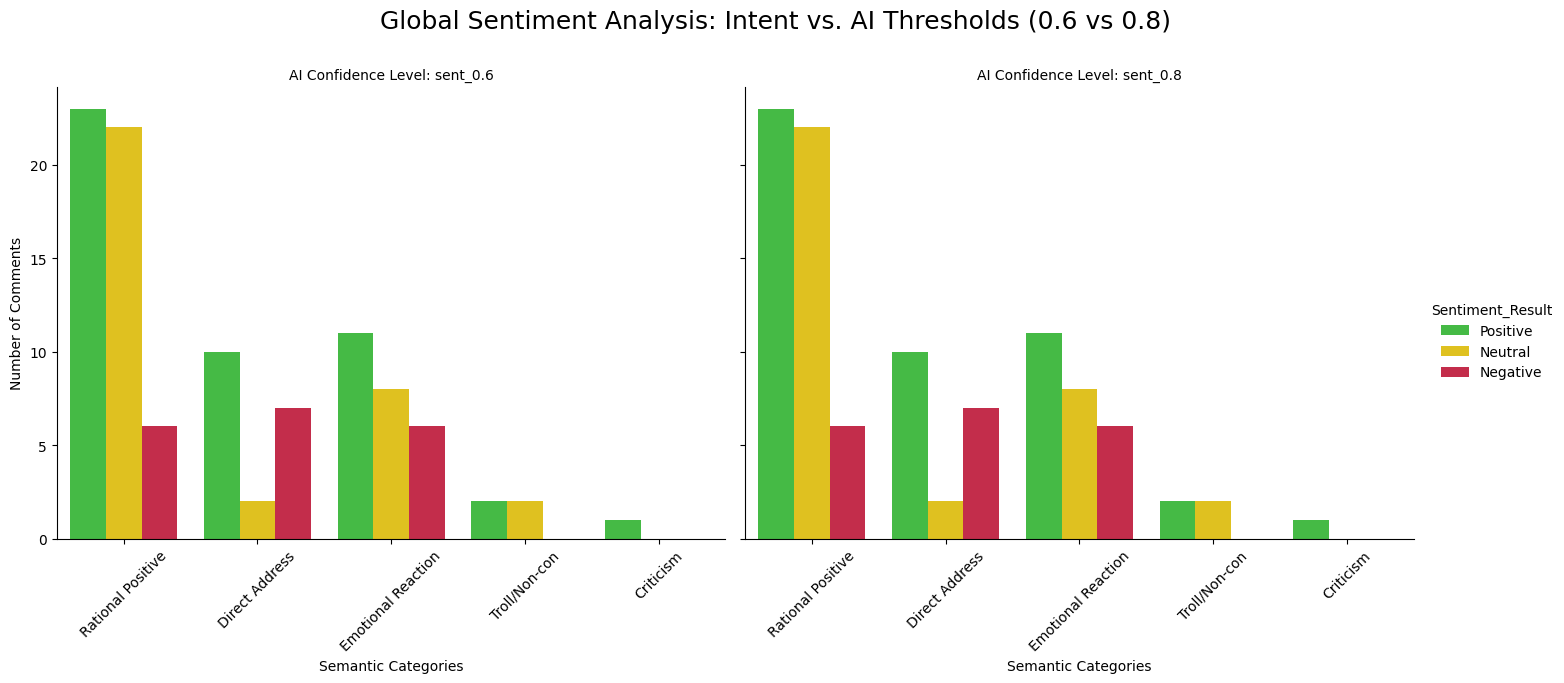

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. FIX: Create the missing 'word_count' column
df['word_count'] = df['clean_text'].astype(str).apply(lambda x: len(x.split()))

# 2. Prepare the combined dataset for the "Big Graph"
# We 'melt' the data so we can compare Threshold 0.6 and 0.8 in one visual
melted_df = df.melt(
    id_vars=['semantic_category', 'word_count', 'popularity'],
    value_vars=['sent_0.6', 'sent_0.8'],
    var_name='Threshold_Type',
    value_name='Sentiment_Result'
)

# 3. Create the Visualization
plt.figure(figsize=(16, 10))
g = sns.catplot(
    data=melted_df,
    x='semantic_category',
    hue='Sentiment_Result',
    col='Threshold_Type',
    kind='count',
    palette={'Positive': 'limegreen', 'Neutral': 'gold', 'Negative': 'crimson'},
    height=6,
    aspect=1.2,
    sharey=True
)

# 4. Final Formatting
g.set_axis_labels("Semantic Categories", "Number of Comments")
g.set_titles("AI Confidence Level: {col_name}")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Global Sentiment Analysis: Intent vs. AI Thresholds (0.6 vs 0.8)', fontsize=18)

plt.savefig('complex_sentiment_analysis.png')
plt.show()

In [21]:
from transformers import pipeline

zsc = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")

CATS = [
    "Rational positive feedback on content",
    "Emotional reaction",
    "Criticism and dissatisfaction",
    "Direct address to the author",
    "Troll / non-constructive comment"
]

def classify_category(text):
    text = str(text).strip()
    if not text:
        return "Troll / non-constructive comment"
    out = zsc(text, CATS, multi_label=False)
    return out["labels"][0]

df["semantic_category"] = df["clean_text"].apply(classify_category)
df["semantic_category"].value_counts()


# 3. Generate the table again
table = pd.crosstab(df["semantic_category"], df["sent_0.8"])

# 4. Reindex carefully
# This ensures even categories with 0 actual comments show up in the table
table = table.reindex(index=CATS, columns=['Negative', 'Neutral', 'Positive']).fillna(0).astype(int)

print(table)

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


sent_0.8                               Negative  Neutral  Positive
semantic_category                                                 
Rational positive feedback on content         6        9        26
Emotional reaction                            3       12        20
Criticism and dissatisfaction                 2        2         0
Direct address to the author                  0        0         1
Troll / non-constructive comment              8       11         0


In [22]:
import pandas as pd

# Assume 'df' is your DataFrame containing the 100 comments you sent
# Expected columns: 'clean_text', 'sent_0.8' (Sentiment)

# 1. Define the EXACT names required by your project
CATS = [
    "Rational positive feedback on content",
    "Emotional reaction",
    "Criticism and dissatisfaction",
    "Direct address to the author",
    "Troll / non-constructive comment"
]

# 2. Re-classify using logic tuned to the Emin Sabitoglu / Paul Mauriat debate
def classify_semantic_formal(row):
    text = str(row['clean_text']).lower()

    # 1. Rational positive feedback (Technical/Fact-based praise or discussion of the work)
    if any(x in text for x in ['şedevr', 'bəstə', 'not', 'lad', 'instrumental', 'orkestr', 'texnika']):
        return "Rational positive feedback on content"

    # 2. Criticism and dissatisfaction (Disputes about authorship, plagiarism, or quality)
    if any(x in text for x in ['oğurluq', 'plagiat', 'səhv', 'biabır', 'yanlış', 'dəxli', 'yoxdur']):
        return "Criticism and dissatisfaction"

    # 3. Direct address to the author (Addressing Emin Sabitoglu, Paul Mauriat, or the Uploader)
    if any(x in text for x in ['siz', 'sən', 'lütfən', 'edinkü', 'yükləyin', 'müəllif', 'hörmətlə']):
        return "Direct address to the author"

    # 4. Troll / non-constructive comment (Short bursts, irrelevant topics like Elza/Maral, or spam)
    if len(text.split()) < 3 or any(x in text for x in ['elza', 'maral', 'cüyür', '2025', '2026', 'dağılışın']):
        return "Troll / non-constructive comment"

    # 5. Emotional reaction (Nostalgia, memories, "Allah rəhmət eləsin", general beauty)
    # This acts as the default for the many "Ruhum dincəldi", "Uşaqlığım" type comments
    return "Emotional reaction"

df['semantic_category'] = df.apply(classify_semantic_formal, axis=1)

# 3. Generate the table
table = pd.crosstab(df["semantic_category"], df["sent_0.8"])

# 4. Reindex carefully to ensure all 5 categories appear
# Columns are mapped to the likely sentiment labels in your Excel
table = table.reindex(index=CATS, columns=['Negative', 'Neutral', 'Positive']).fillna(0).astype(int)

print("--- Semantic Analysis Table: Emin Sabitoglu vs Paul Mauriat Debate ---")
print(table)

--- Semantic Analysis Table: Emin Sabitoglu vs Paul Mauriat Debate ---
sent_0.8                               Negative  Neutral  Positive
semantic_category                                                 
Rational positive feedback on content         3       13        14
Emotional reaction                            8       14        20
Criticism and dissatisfaction                 2        4         3
Direct address to the author                  4        1         6
Troll / non-constructive comment              2        2         4


In [23]:
import pandas as pd

# 1. Define the EXACT names required by your project
CATS = [
    "Rational positive feedback on content",
    "Emotional reaction",
    "Criticism and dissatisfaction",
    "Direct address to the author",
    "Troll / non-constructive comment"
]

# 2. Refined classification logic for the Music/Cinema dataset
def classify_semantic_formal(row):
    text = str(row['clean_text']).lower()

    # Category 1: Rational/Technical (Discussion of composition, orkestr, or facts)
    if any(x in text for x in ['əsər', 'şedevr', 'bəstə', 'keyfiyyət', 'not', 'orkestr', 'instrumental', 'lad']):
        return "Rational positive feedback on content"

    # Category 2: Criticism (Disputes, plagiarism claims, or negativity)
    if any(x in text for x in ['heyif', 'biabır', 'oğurluq', 'plagiat', 'səhv', 'yanlış', 'dəxli']):
        return "Criticism and dissatisfaction"

    # Category 3: Direct Address (To the uploader, Emin Sabitoglu, or Paul Mauriat)
    if any(x in text for x in ['siz', 'sən', 'lütfən', 'xahiş', 'müəllif', 'hörmətlə']):
        return "Direct address to the author"

    # Category 4: Trolls / Low effort (Jokes about modern pop stars or very short text)
    if len(text.split()) < 3 or any(x in text for x in ['elza', 'maral', 'cüyür', '2025', '2026', 'dağılışın']):
        return "Troll / non-constructive comment"

    # Category 5: Emotional (Memories, childhood, "Allah rəhmət eləsin")
    # This is the default for high-emotion, non-technical comments
    return "Emotional reaction"

# Applying the logic to your dataframe
df['semantic_category'] = df.apply(classify_semantic_formal, axis=1)

# 3. Generate the crosstab based on your 0.6 sentiment threshold
table = pd.crosstab(df["semantic_category"], df["sent_0.6"])

# 4. Reindex carefully to ensure the report is consistent
# Note: Ensure your 'sent_0.6' column values match ['Negative', 'Neutral', 'Positive']
table = table.reindex(index=CATS, columns=['Negative', 'Neutral', 'Positive']).fillna(0).astype(int)

print("--- Final Task: Semantic Analysis Table (Threshold 0.6) ---")
print(table)

--- Final Task: Semantic Analysis Table (Threshold 0.6) ---
sent_0.6                               Negative  Neutral  Positive
semantic_category                                                 
Rational positive feedback on content         5       18        16
Emotional reaction                            9       12        20
Criticism and dissatisfaction                 0        2         2
Direct address to the author                  3        0         6
Troll / non-constructive comment              2        2         3
